<a href="https://colab.research.google.com/github/juneshuai/DataProject/blob/main/unsplash%2Bpapago%2Bpix2pix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/openai/CLIP.git
!pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-rvy1jf7q
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-rvy1jf7q
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [ ]:
import clip
import torch

# Load the open CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [ ]:
from pathlib import Path

# Create a folder for the precomputed features
!mkdir unsplash-dataset

# Download from Github Releases
if not Path('unsplash-dataset/photo_ids.csv').exists():
  !wget https://github.com/haltakov/natural-language-image-search/releases/download/1.0.0/photo_ids.csv -O unsplash-dataset/photo_ids.csv

if not Path('unsplash-dataset/features.npy').exists():
  !wget https://github.com/haltakov/natural-language-image-search/releases/download/1.0.0/features.npy -O unsplash-dataset/features.npy
  

mkdir: cannot create directory ‘unsplash-dataset’: File exists


In [ ]:
import pandas as pd
import numpy as np

# Load the photo IDs
photo_ids = pd.read_csv("unsplash-dataset/photo_ids.csv")
photo_ids = list(photo_ids['photo_id'])

# Load the features vectors
photo_features = np.load("unsplash-dataset/features.npy")

# Convert features to Tensors: Float32 on CPU and Float16 on GPU
if device == "cpu":
  photo_features = torch.from_numpy(photo_features).float().to(device)
else:
  photo_features = torch.from_numpy(photo_features).to(device)

# Print some statistics
print(f"Photos loaded: {len(photo_ids)}")

Photos loaded: 1981161


In [ ]:
def encode_search_query(search_query):
  with torch.no_grad():
    # Encode and normalize the search query using CLIP
    text_encoded = model.encode_text(clip.tokenize(search_query).to(device))
    text_encoded /= text_encoded.norm(dim=-1, keepdim=True)

  # Retrieve the feature vector
  return text_encoded

In [ ]:
def find_best_matches(text_features, photo_features, photo_ids, results_count=3):
  # Compute the similarity between the search query and each photo using the Cosine similarity
  similarities = (photo_features @ text_features.T).squeeze(1)

  # Sort the photos by their similarity score
  best_photo_idx = (-similarities).argsort()

  # Return the photo IDs of the best matches
  return [photo_ids[i] for i in best_photo_idx[:results_count]]

In [ ]:
from IPython.display import Image
from IPython.core.display import HTML
import cv2
import urllib.request
from urllib import request

def display_photo(photo_id):
  # Get the URL of the photo resized to have a width of 320px
  photo_image_url = f"https://unsplash.com/photos/{photo_id}/download?w=320"
  
  # Display the photo
  display(Image(url=photo_image_url))
  print("photo id : {}.png".format(photo_id))
  request.urlretrieve(photo_image_url,"{}.png".format(photo_id))

  

  # Display the attribution text
  display(HTML(f'Photo on <a target="_blank" href="https://unsplash.com/photos/{photo_id}">Unsplash</a> '))
  print()

In [ ]:
def search_unslash(search_query, photo_features, photo_ids, results_count=3):
  # Encode the search query
  text_features = encode_search_query(search_query)

  # Find the best matches
  best_photo_ids = find_best_matches(text_features, photo_features, photo_ids, results_count)

  # Display the best photos
  for photo_id in best_photo_ids:
    display_photo(photo_id)


**파파고 번역** 코드

In [ ]:
import requests

def get_translate(text):
    client_id = "VS68zCj4KvXKRD7avvi6" # <-- client_id 기입
    client_secret = "WYDQls3eBJ" # <-- client_secret 기입

    data = {'text' : text,
            'source' : 'ko',
            'target': 'en'}

    url = "https://openapi.naver.com/v1/papago/n2mt"

    header = {"X-Naver-Client-Id":client_id,
              "X-Naver-Client-Secret":client_secret}

    response = requests.post(url, headers=header, data=data)
    rescode = response.status_code

    if(rescode==200):
        send_data = response.json()
        trans_data = (send_data['message']['result']['translatedText'])
        return trans_data
    else:
        print("Error Code:" , rescode)



In [ ]:
#@title 검색 
#@markdown 한국어로 작성하세요

search_KOR = '\uD654\uCC3D\uD55C \uACF5\uC6D0' #@param {type:"string"}

search_query = get_translate(search_KOR)

search_unslash(search_query, photo_features, photo_ids, 3)

photo id : dB17-GtKfuw.png


photo id : ZxpVkIOJDxc.png


photo id : OpPy_wlled4.png


In [ ]:
#구글 드라이브 마운트

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image

# U-Net 아키텍처의 다운 샘플링(Down Sampling) 모듈
class UNetDown(nn.Module):
    def __init__(self, in_channels, out_channels, normalize=True, dropout=0.0):
        super(UNetDown, self).__init__()
        # 너비와 높이가 2배씩 감소
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


# U-Net 아키텍처의 업 샘플링(Up Sampling) 모듈: Skip Connection 사용
class UNetUp(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.0):
        super(UNetUp, self).__init__()
        # 너비와 높이가 2배씩 증가
        layers = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False)]
        layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.ReLU(inplace=True))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1) # 채널 레벨에서 합치기(concatenation)

        return x


# U-Net 생성자(Generator) 아키텍처
class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(GeneratorUNet, self).__init__()

        self.down1 = UNetDown(in_channels, 64, normalize=False) # 출력: [64 X 128 X 128]
        self.down2 = UNetDown(64, 128) # 출력: [128 X 64 X 64]
        self.down3 = UNetDown(128, 256) # 출력: [256 X 32 X 32]
        self.down4 = UNetDown(256, 512, dropout=0.5) # 출력: [512 X 16 X 16]
        self.down5 = UNetDown(512, 512, dropout=0.5) # 출력: [512 X 8 X 8]
        self.down6 = UNetDown(512, 512, dropout=0.5) # 출력: [512 X 4 X 4]
        self.down7 = UNetDown(512, 512, dropout=0.5) # 출력: [512 X 2 X 2]
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5) # 출력: [512 X 1 X 1]

        # Skip Connection 사용(출력 채널의 크기 X 2 == 다음 입력 채널의 크기)
        self.up1 = UNetUp(512, 512, dropout=0.5) # 출력: [1024 X 2 X 2]
        self.up2 = UNetUp(1024, 512, dropout=0.5) # 출력: [1024 X 4 X 4]
        self.up3 = UNetUp(1024, 512, dropout=0.5) # 출력: [1024 X 8 X 8]
        self.up4 = UNetUp(1024, 512, dropout=0.5) # 출력: [1024 X 16 X 16]
        self.up5 = UNetUp(1024, 256) # 출력: [512 X 32 X 32]
        self.up6 = UNetUp(512, 128) # 출력: [256 X 64 X 64]
        self.up7 = UNetUp(256, 64) # 출력: [128 X 128 X 128]

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2), # 출력: [128 X 256 X 256]
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, out_channels, kernel_size=4, padding=1), # 출력: [3 X 256 X 256]
            nn.Tanh(),
        )

    def forward(self, x):
        # 인코더부터 디코더까지 순전파하는 U-Net 생성자(Generator)
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)

        return self.final(u7)


# U-Net 판별자(Discriminator) 아키텍처
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_channels, out_channels, normalization=True):
            # 너비와 높이가 2배씩 감소
            layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            # 두 개의 이미지(실제/변환된 이미지, 조건 이미지)를 입력 받으므로 입력 채널의 크기는 2배
            *discriminator_block(in_channels * 2, 64, normalization=False), # 출력: [64 X 128 X 128]
            *discriminator_block(64, 128), # 출력: [128 X 64 X 64]
            *discriminator_block(128, 256), # 출력: [256 X 32 X 32]
            *discriminator_block(256, 512), # 출력: [512 X 16 X 16]
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, kernel_size=4, padding=1, bias=False) # 출력: [1 X 16 X 16]
        )

    # img_A: 실제/변환된 이미지, img_B: 조건(condition)
    def forward(self, img_A, img_B):
        # 이미지 두 개를 채널 레벨에서 연결하여(concatenate) 입력 데이터 생성
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)


def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [ ]:
transforms_ = transforms.Compose([
    transforms.Resize((256, 256), Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
# 모델 불러오기
generator = GeneratorUNet()
discriminator = Discriminator()

generator.cuda()
discriminator.cuda()

generator.load_state_dict(torch.load("/content/drive/MyDrive/Pix2Pix_Generator_for_Anime_Sketch.pt"))
discriminator.load_state_dict(torch.load("/content/drive/MyDrive/Pix2Pix_Discriminator_for_Anime_Sketch.pt"))

generator.eval();
discriminator.eval();

FileNotFoundError: ignored

In [ ]:
from __future__ import print_function
import argparse

from torch.autograd import Variable

import PIL.Image
import PIL.ImageTk
import cv2
from google.colab.patches import cv2_imshow
from IPython.display import Image


def is_image_file(filename):
    return any(filename.endswith(extension) for extension in [".png", ".jpg", ".jpeg"])


def load_img(filepath):
    img = PIL.Image.open(filepath).convert('RGB')
    img = img.resize((256, 256))
    return img


def save_img(image_tensor, filename):
    image_numpy = image_tensor.float().numpy()
    image_numpy = (np.transpose(image_numpy, (1, 2, 0)) + 1) / 2.0 * 255.0
    image_numpy = image_numpy.astype(np.uint8)
    image_pil = Image.fromarray(image_numpy)
    image_pil.save(filename)
    print("Image saved as {}".format(filename))


parser = argparse.ArgumentParser()
parser.add_argument('--dataset', required=False, default='illustration', help='illustration')
parser.add_argument('--model', required=False, type=str, default='Pix2Pix_Generator_for_Anime_Sketch.pt1의 사본', help='model file to use')
parser.add_argument('--cuda', action='store_true', default=True, help='use cuda')
params = parser.parse_args([])
print(params)


Namespace(cuda=True, dataset='illustration', model='Pix2Pix_Generator_for_Anime_Sketch.pt1의 사본')


In [ ]:
from glob import glob
unsplash_outputs = glob('/content/*.png')

In [ ]:
for idx, unsplash_output in enumerate(unsplash_outputs):
    imgs = load_img(unsplash_output)
    imgs = transforms_(imgs)

    input = Variable(imgs).view(1,-1,256,256)
    input_img = input.data[0]

    if params.cuda:
        generator = generator.cuda()
        input = input.cuda()

    out = generator(input)
    out = out.cpu()
    out_img = out.data[0]
    save_image(out_img, "result{}.png".format(idx), nrow=1, normalize=True)
  

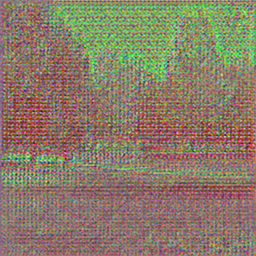

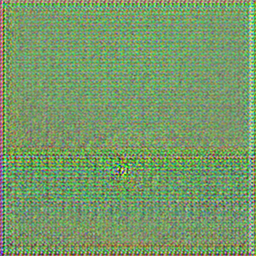

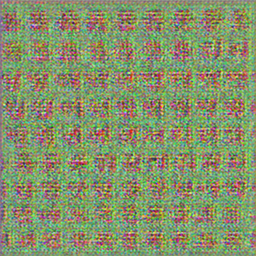

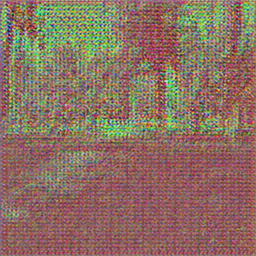

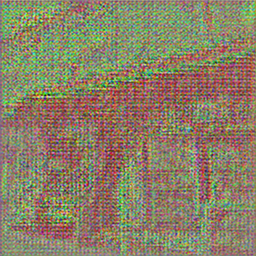

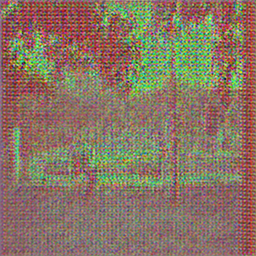

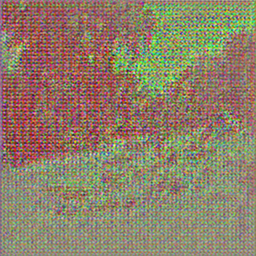

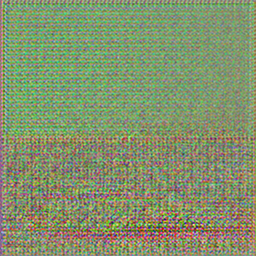

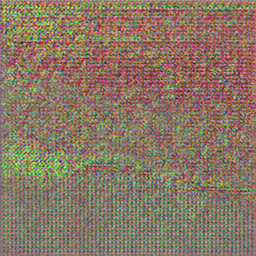

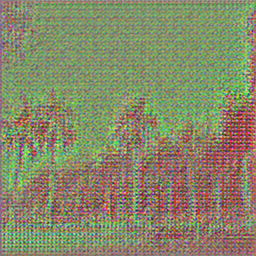

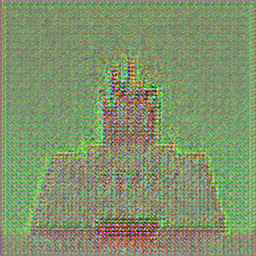

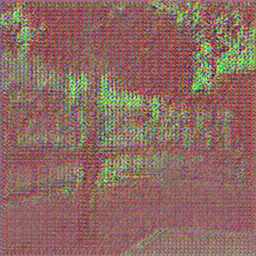

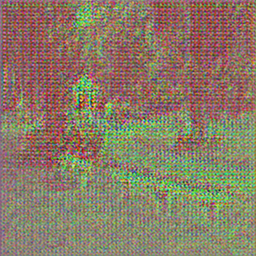

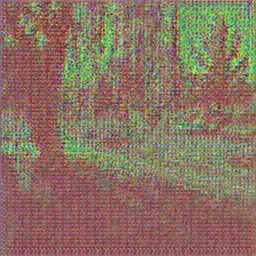

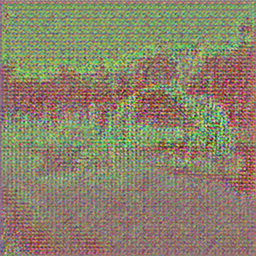

In [ ]:
from IPython.display import Image, display
listOfImageNames = glob('/content/result*.png')

for imageName in listOfImageNames:
    display(Image(filename=imageName))
    print()